# Normalizing flows: binary classification with input estimation

## Load packages

In [1]:
using Random
using LinearAlgebra
using PyPlot
using Distributions
using BenchmarkTools
using ProgressMeter
using Optim
using Revise

using ReactiveMP
using GraphPPL
using Rocket;

## Generate data

In [2]:
function generate_data(nr_samples::Int64)

    # sample weights
    w = rand(nr_samples,2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        if w[k,1] > 0.6 && w[k,1] < 0.9 && w[k,2] < 0.4 && w[k,2] > 0.1
            y[k] = 1.0
        elseif w[k,1] < 0.5 || w[k,2] > 0.5 
            y[k] = 0.0
        else
            y[k] = 1.0 * (rand() > 0.5)
        end
    end

    # return data
    return y, w

end;

In [3]:
data_y, data_x = generate_data(200);

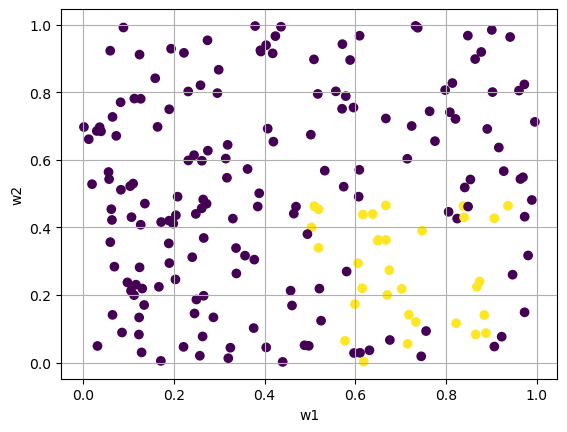

In [4]:
plt.scatter(data_x[:,1], data_x[:,2], c=data_y)
plt.grid()
plt.xlabel("w1")
plt.ylabel("w2");

## Model specification

In [5]:
# specify flow model
model = FlowModel(2,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
)   

FlowModel{8,Tuple{ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64},ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64},ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64},ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}},PermutationLayer{Int64}}}(2, (ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), ReactiveMP.AdditiveCouplingLayerEmpty{ReactiveMP.PlanarFlowEmpty{1}}(2, ReactiveMP.PlanarFlowEmpty{1}(Val{1}()), 1), PermutationLayer

In [6]:
@model function flow_classifier(nr_samples::Int64, model::FlowModel, params)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # specify model
    meta  = FlowMeta(compile(model, params))

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k]) where { meta = meta }
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

## Probabilistic Inference

In [7]:
function inference_flow_classifier(data_y::Array{Float64,1}, data_x::Array{Array{Float64,1},1}, model::FlowModel, params)
    
    # fetch number of samples
    nr_samples = length(data_y)

    # define model
    model, (x_lat, x, y_lat1, y_lat2, y) = flow_classifier(nr_samples, model, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    # update y and x according to observations (i.e. perform inference)
    ReactiveMP.update!(y, data_y)
    ReactiveMP.update!(x, data_x)

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [8]:
function f(params)
    fe = inference_flow_classifier(data_y, [data_x[k,:] for k=1:size(data_x,1)], model, params)
    return fe
end;

## Experimental validation

In [9]:
res = optimize(f, randn(nr_params(model)), LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     5.375572e+03     4.251427e+03
 * time: 0.026999950408935547
     1     5.554843e+02     3.982820e+02
 * time: 1.0409998893737793
     2     1.236141e+02     4.934896e+01
 * time: 1.363999843597412
     3     7.169933e+01     5.312535e+01
 * time: 1.5249998569488525
     4     6.646527e+01     7.550021e+01
 * time: 1.684999942779541
     5     5.952958e+01     2.596028e+01
 * time: 1.7949998378753662
     6     5.757633e+01     5.275128e+01
 * time: 1.9570000171661377
     7     5.428964e+01     1.444093e+01
 * time: 2.1369998455047607
     8     5.211847e+01     3.491318e+01
 * time: 2.294999837875366
     9     4.977463e+01     2.253117e+01
 * time: 2.504999876022339
    10     4.911956e+01     8.132469e+00
 * time: 2.619999885559082
    11     4.898007e+01     5.944757e+00
 * time: 2.7869999408721924
    12     4.870849e+01     1.421266e+01
 * time: 2.9559998512268066
    13     4.752671e+01     3.386642e+01
 * time: 3.1319999694824

 * Status: success

 * Candidate solution
    Final objective value:     3.732408e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.98e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   39  (vs limit Inf)
    Iterations:    91
    f(x) calls:    698
    ∇f(x) calls:   698


In [10]:
function uniformpdf(y; xmin = 0, xmax = 1, ymin = 0, ymax = 1)
    indomain = 1.0*(xmin <= y[1] <= xmax)*(ymin <= y[2] <= ymax)
    return indomain/(xmax-xmin)/(ymax-ymin)
end

uniformpdf (generic function with 1 method)

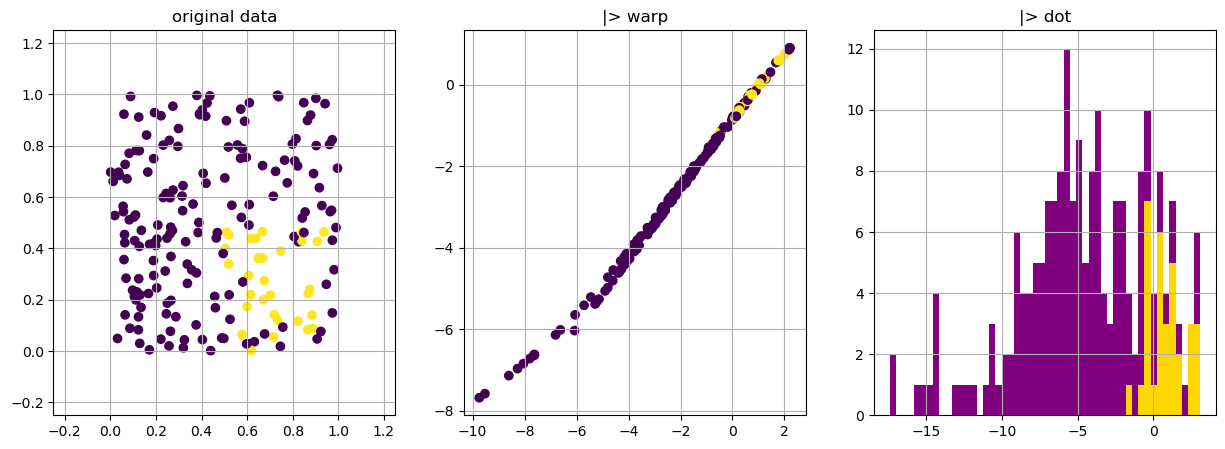

In [11]:
params = Optim.minimizer(res)
inferred_model = compile(model, params)
trans_data_x_1 = hcat(map((x) -> forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .== 1.0], trans_data_x_2[data_y .== 0.0]]
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[2].scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], c = data_y)
ax[3].hist(trans_data_x_2_split; stacked=true, bins=50, color = ["gold", "purple"])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-0.25,1.25), ax[1].set_ylim(-0.25,1.25)
ax[1].set_title("original data"), ax[2].set_title("|> warp"), ax[3].set_title("|> dot");

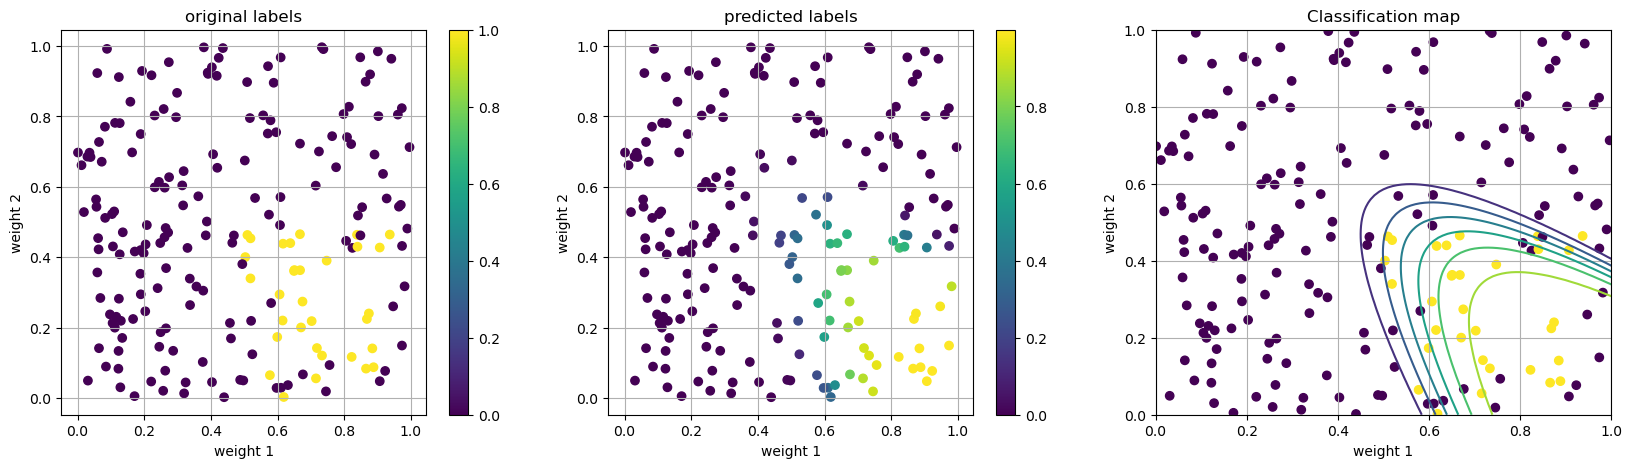

In [12]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))
im1 = ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
im2 = ax[2].scatter(data_x[:,1], data_x[:,2], c = normcdf.(trans_data_x_2))
ax[3].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[3].contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlabel("weight 1"), ax[1].set_ylabel("weight 2"), ax[2].set_xlabel("weight 1"), ax[2].set_ylabel("weight 2"), ax[3].set_xlabel("weight 1"), ax[3].set_ylabel("weight 2")
ax[1].set_title("original labels"), ax[2].set_title("predicted labels"), ax[3].set_title("Classification map");

# Weight optimization

In [13]:
struct PointMassFormConstraint2{P}
    point :: P   
end

ReactiveMP.default_form_check_strategy(::PointMassFormConstraint2) = FormConstraintCheckLast()

ReactiveMP.is_point_mass_form_constraint(::PointMassFormConstraint2) = true

function ReactiveMP.constrain_form(pmconstraint::PointMassFormConstraint2, message::Message) 
    is_clamped = ReactiveMP.is_clamped(message)
    is_initial = ReactiveMP.is_initial(message)
    return Message(PointMass(pmconstraint.point), is_clamped, is_initial)
end


In [14]:
@model function flow_classifier_input(input, model, params)
    
    # initialize variables
    x_lat  = randomvar()
    y_lat1 = randomvar()
    y_lat2 = randomvar()
    xprior = randomvar() where { form_constraint = PointMassFormConstraint2(input)}
    y = datavar(Float64)

    # specify model
    meta  = FlowMeta(compile(model, params))

    # specify prior on weights
    xprior ~ MvNormalMeanPrecision([0.5,0.5], 1*diagm(ones(2))) where { q = MeanField() }

    # specify latent state
    x_lat ~ MvNormalMeanPrecision(xprior, 1e3*diagm(ones(2))) where { q = MeanField() }

    # specify transformed latent value
    y_lat1 ~ Flow(x_lat) where { meta = meta }
    y_lat2 ~ dot(y_lat1, [1, 1])

    # specify observations
    y ~ Probit(y_lat2) # default where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    # return variables
    return x_lat, y_lat1, y_lat2, y

end;

In [15]:
function inference_flow_classifier_input(input, model, params)

    # define model
    model, (x_lat, y_lat1, y_lat2, y) = flow_classifier_input(input, model, params)

    # initialize free energy
    fe_buffer = nothing
    
    # subscribe
    fe_sub = subscribe!(score(eltype(input), BetheFreeEnergy(), model), (fe) -> fe_buffer = fe)

    setmarginal!(x_lat, vague(MvNormalMeanPrecision, 2))
    
    # update y and x according to observations (i.e. perform inference)
    for k = 1:10
        ReactiveMP.update!(y, 1.0)
    end

    # unsubscribe
    unsubscribe!(fe_sub)
    
    # return the marginal values
    return fe_buffer

end;

In [16]:
function f_input(input)
    fe = inference_flow_classifier_input(input, model, params)
    return fe
end;

In [17]:
res = optimize(f_input, rand(2), LBFGS(), Optim.Options(iterations = 100, store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     5.378449e+02     3.953812e+03
 * time: 0.0
     1     5.130806e+02     2.782893e+03
 * time: 0.018000125885009766
     2     4.994886e+02     1.011726e+03
 * time: 0.023000001907348633
     3     4.979985e+02     9.575180e+02
 * time: 0.029000043869018555
     4     4.874982e+02     2.378569e+03
 * time: 0.037000179290771484
     5     2.340201e+00     8.055436e-01
 * time: 0.042999982833862305
     6     2.234509e+00     8.138864e-01
 * time: 0.054000139236450195
     7     2.203712e+00     5.110104e+00
 * time: 0.06200003623962402
     8     2.203363e+00     1.066755e+00
 * time: 0.06599998474121094
     9     2.200129e+00     1.530066e+00
 * time: 0.07299995422363281
    10     2.199831e+00     2.069121e+00
 * time: 0.07700014114379883
    11     2.199832e+00     2.148981e+00
 * time: 0.10100007057189941
    12     2.164331e+00     1.210631e+01
 * time: 0.10899996757507324
    13     2.088652e+00     1.126774e+00
 * time: 0.1219999

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     2.074964e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.76e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.41e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.96e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.87e-08 ≰ 0.0e+00
    |g(x)|                 = 5.78e-05 ≰ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    100
    f(x) calls:    383
    ∇f(x) calls:   383


In [18]:
optimum = Optim.minimizer(res)

2-element Array{Float64,1}:
  0.8985642696599438
 -0.04396528813745053

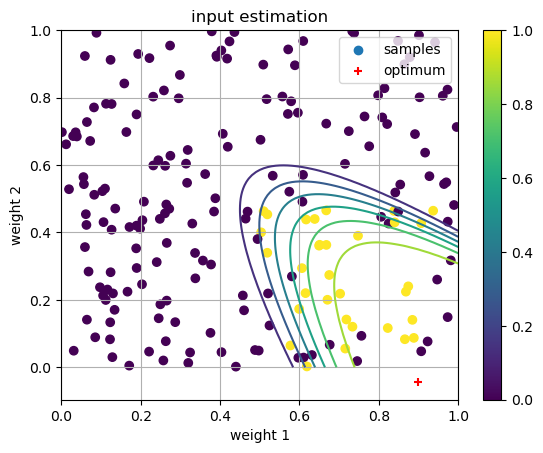

In [19]:
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
plt.scatter(data_x[:,1], data_x[:,2], c = data_y, label="samples")
plt.contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.scatter(optimum[1], optimum[2], c = "red", marker = "+", label="optimum")
plt.colorbar()
plt.grid()
plt.legend()
plt.xlabel("weight 1"), plt.ylabel("weight 2"), plt.title("input estimation");

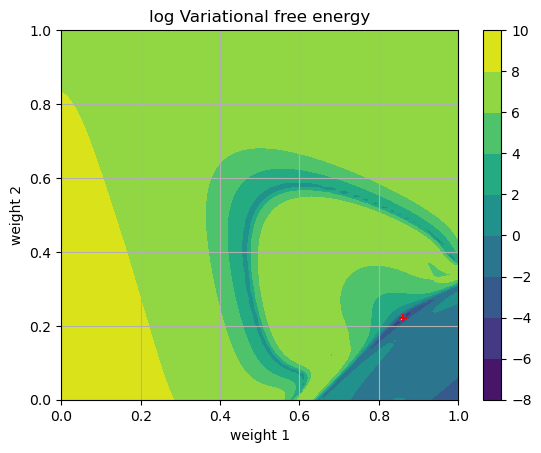

In [20]:
output_range = map((x) -> f_input([x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1)))
output_range[isnan.(output_range)] .= Inf
optimum = minimum(output_range)
im = plt.contourf(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', log.(output_range .- minimum(output_range)))
plt.scatter(collect(0:0.01:1)[findfirst((x) -> x == optimum, output_range)[1]], collect(0:0.01:1)[findfirst((x) -> x == optimum, output_range)[2]], c="red", marker="+")
plt.colorbar(im)
plt.grid()
plt.xlabel("weight 1"), plt.ylabel("weight 2")
plt.title("log Variational free energy");